In [1]:
import numpy as np
import pandas as pd

In [2]:
# https://kdd.ics.uci.edu/databases/kddcup99/training_attack_types
# Attack name and type
data = '''back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2l'''

In [3]:
# grouped by type
attack_types = pd.DataFrame([row.split() for row in data.split('\n')], columns=['name','type'])
attack_type_groups = attack_types.groupby('type')['name'].unique()

print('attack group types: {}'.format(', '.join(attack_type_groups.index)))
print()
print(attack_type_groups)

attack group types: dos, probe, r2l, u2r

type
dos            [back, land, neptune, pod, smurf, teardrop]
probe                    [ipsweep, nmap, portsweep, satan]
r2l      [ftp_write, guess_passwd, imap, multihop, phf,...
u2r           [buffer_overflow, loadmodule, perl, rootkit]
Name: name, dtype: object


In [4]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml(data_id='1113', return_X_y=True, as_frame=True)
print('n records: {}'.format(len(X.index)))
X_preserved = X.copy()
y_preserved = y.copy()

n records: 494020


In [8]:
list(X.columns.values)

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'lnum_compromised',
 'lroot_shell',
 'lsu_attempted',
 'lnum_root',
 'lnum_file_creations',
 'lnum_shells',
 'lnum_access_files',
 'lnum_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [5]:
# run as an alternative to the above, as needed
#X = X_preserved.copy()
#y = y_preserved.copy()

In [5]:
def get_attack_type_downsampled_balanced_subset(attack_names, label, X, y):
    print('Attack group name: {}'.format(label))
    print('Attack_types: {}'.format(', '.join(attack_names)))
    
    is_type_attack = y.isin(attack_names)
    
    only_attack_type = y[is_type_attack]
    only_not_attack_type = y[~is_type_attack]
    
    only_attack_type = is_type_attack[is_type_attack]
    only_not_attack_type = is_type_attack[~is_type_attack]
    
    
    num_attack_type = only_attack_type.shape[0]
    num_not_attack_type = only_not_attack_type.shape[0]
    
    print('Num attack type: {}'.format(num_attack_type))
    print('Num not attack type: {}'.format(num_not_attack_type))
    

    # Take a balanced sample
    # which one has less? that is the one we should downsample
    lowest_count = min(num_attack_type, num_not_attack_type)
    
    balanced_ys = []
    balanced_Xs = []
    for subset_y in [only_attack_type, only_not_attack_type]:
        _subset_y = subset_y.copy()
        if _subset_y.shape[0] > lowest_count:
            _subset_y = subset_y.sample(n=lowest_count)
        subset_X = X.loc[_subset_y.index, :]
        balanced_Xs.append(subset_X)
        balanced_ys.append(_subset_y)
    
    assert len(balanced_Xs) == len(balanced_ys)
    
    for i, balanced_y in enumerate(balanced_ys):
        assert balanced_y.shape[0] == lowest_count
        assert balanced_Xs[i].shape[0] == lowest_count
        
    X_new = pd.concat(balanced_Xs)
    y_new = pd.concat(balanced_ys).rename(label)
    
    print(X_new.shape[0])
    print(y_new.shape[0])
    print()
    
    return X_new, y_new

In [6]:
X_is_dos, y_is_dos = get_attack_type_downsampled_balanced_subset(attack_type_groups['dos'], 'is_dos_attack', X, y)
X_is_probe, y_is_probe = get_attack_type_downsampled_balanced_subset(attack_type_groups['probe'], 'is_probe_attack', X, y)
X_is_r2l, y_is_r2l = get_attack_type_downsampled_balanced_subset(attack_type_groups['r2l'], 'is_r2l_attack', X, y)
X_is_u2r, y_is_u2r = get_attack_type_downsampled_balanced_subset(attack_type_groups['u2r'], 'is_u2r_attack', X, y)

Attack group name: is_dos_attack
Attack_types: back, land, neptune, pod, smurf, teardrop
Num attack type: 391458
Num not attack type: 102562
205124
205124

Attack group name: is_probe_attack
Attack_types: ipsweep, nmap, portsweep, satan
Num attack type: 4107
Num not attack type: 489913
8214
8214

Attack group name: is_r2l_attack
Attack_types: ftp_write, guess_passwd, imap, multihop, phf, spy, warezclient, warezmaster
Num attack type: 1126
Num not attack type: 492894
2252
2252

Attack group name: is_u2r_attack
Attack_types: buffer_overflow, loadmodule, perl, rootkit
Num attack type: 52
Num not attack type: 493968
104
104



In [12]:
y_is_dos.value_counts()

True     102562
False    102562
Name: is_dos_attack, dtype: int64

In [13]:
# Which one to run the following analyses on? Options are the pairs generated in the cell above
X, y = X_is_probe, y_is_probe

In [14]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
# https://www.kaggle.com/gautham11/building-a-scikit-learn-classification-pipeline
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

np.random.seed(0)

# We create the preprocessing pipelines for both numeric and categorical data.
#numeric_features = ['duration']
numeric_features = ['src_bytes','dst_bytes']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['protocol_type']
#categorical_features = []
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
model score: 0.695
average precision score: 0.744
roc_auc_score: 0.817
precision-recall AUC: 0.819



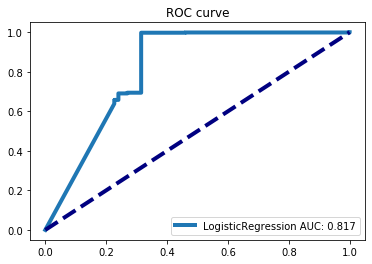

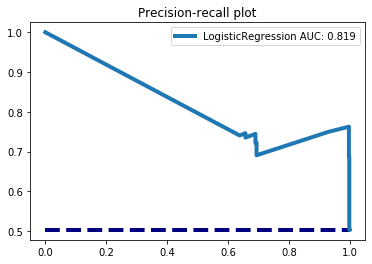

In [20]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# [plot ROC curve sklearn](https://stackoverflow.com/a/47562197/5917194)
# [Precision-recall AUC](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)
# [Average precision and AUC precision-recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import pickle as pkl


# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
classifiers = [
    LogisticRegression(),
    #DecisionTreeClassifier(),
    #RandomForestClassifier(),
    #GaussianNB()
    #MLPClassifier()
    #KNeighborsClassifier()
]

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', None)])

# [introduction pyplot tutorial](https://matplotlib.org/tutorials/introductory/pyplot.html)
# [separate figures](https://matplotlib.org/tutorials/intermediate/artists.html)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

roc_things = []
precision_recall_things = []

for classifier in classifiers:
    clf.set_params(clf=classifier).fit(X_train, y_train)
    classifier_name = classifier.__class__.__name__
    print(str(classifier))
    print("model score: %.3f" % clf.score(X_test, y_test))
    
    
    y_score = clf.predict_proba(X_test)[:,1]
    
    roc_auc = roc_auc_score(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_things.append((fpr, tpr, '{} AUC: {:.3f}'.format(classifier_name, roc_auc)))
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    pr_auc = auc(recall, precision)
    precision_recall_things.append((recall, precision, thresholds, '{} AUC: {:.3f}'.format(classifier_name, pr_auc)))
    #plot_precision_recall_curve(clf, X_test, y_test)
    
    print('average precision score: {:.3f}'.format(average_precision_score(y_test, y_score)))
    print('roc_auc_score: {:.3f}'.format(roc_auc))
    print('precision-recall AUC: {:.3f}'.format(pr_auc))
    print()
    
    with open('{}.pkl'.format(classifier_name), 'wb') as f:
        pkl.dump(clf, f)

roc_plt = plt.figure()
lw = 4
for roc_thing in roc_things:
    fpr, tpr, label = roc_thing
    plt.plot(fpr, tpr, lw=lw, label=label)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # dadgum no-skill line
plt.legend()
plt.title('ROC curve')
          
pr_plt = plt.figure()
for pr_thing in precision_recall_things:
    recall, precision, _, label = pr_thing
    plt.plot(recall, precision, lw=lw, label=label)
ratio = y_test[y_test].shape[0] / y_test.shape[0]
plt.hlines(y=ratio, xmin=0, xmax=1, color='navy', lw=lw, linestyle='--') # dadgum no-skill line
plt.title('Precision-recall plot')
plt.legend()   

In [17]:
# best was random forest...
from scipy.stats import hmean
import numpy.ma as ma

recall, precision, thresholds, _ = precision_recall_things[0] # random forest

# make a 2D numpy array out of our recall and precision values
a = np.column_stack((recall,precision))

# harmonic mean is only valid for values greater than 0.
# "mask" out any rows with values less than or equal to 0
# https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ma.mask_rows.html
a = ma.masked_less_equal(a, 0)
a = ma.mask_rows(a)
f1 = hmean(a,axis=1)

# np.argmax returns the index of the largest value in an array. This will map to the threshold array that
# was associated with the precision and recall which generated that "best F1 score"
# I'm sure there's a better way to do the above, but IDK I'm a noob
threshold_that_maximizes_f1 = thresholds[np.argmax(f1)]
print('threshold that optimizes f1: {}'.format(threshold_that_maximizes_f1))

threshold that optimizes f1: 0.447694082692155
